In [1]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import seaborn as sns
import time
import gc
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    gc.collect()
    return df


In [3]:
input_dir = "../data/"
output_dir = "../process_data/"

In [4]:
launch = pd.read_csv(input_dir + "app_launch_logs.csv")
launch.date.min(), launch.date.max()

(100, 222)

In [5]:
launch['user_count'] = launch['user_id'].map(launch['user_id'].value_counts())
launch['date_count'] = launch['date'].map(launch['date'].value_counts())

In [6]:
launch.head()

,user_id,launch_type,date,user_count,date_count
0,10157996,0,129,40,70225
1,10139583,0,129,5,70225
2,10277501,0,129,7,70225
3,10099847,0,129,27,70225
4,10532773,0,129,72,70225


In [7]:
launch['launch_type'].value_counts()

0    8110781
1     383097
Name: launch_type, dtype: int64

In [8]:
launch_grp = launch.groupby("user_id").agg(
    launch_date=("date", list),
    launch_type=("launch_type", list),
    user_count=("user_count", np.max),
    launch_data_count=("date_count", list)
).reset_index()
launch_grp
del launch
gc.collect()

0

In [9]:
launch_grp['date_len'] = launch_grp.launch_date.apply(lambda x: max(x)-min(x))

C:\Users\wk\Anaconda\envs\torch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='date_len', ylabel='Density'>

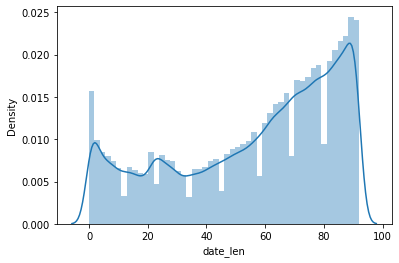

In [10]:
sns.distplot(launch_grp['date_len'])

In [11]:
# generating a sample for each user, a sample should has an anchor date for label
def choose_end_date(launch_date):
    n1, n2 = min(launch_date), max(launch_date)
    if n1 < n2 - 7:
        end_date = np.random.randint(n1, n2 - 7)
    else:
        end_date = np.random.randint(100, 222 - 7)
    return end_date
launch_grp["end_date"] = launch_grp.launch_date.apply(choose_end_date)
launch_grp

,user_id,launch_date,launch_type,user_count,launch_data_count,date_len,end_date
0,10000000,"[195, 192, 196, 193, 191, 141, 187, 202, 132, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19,"[53295, 57640, 53462, 54330, 79968, 98354, 805...",89,146
1,10000001,"[118, 117, 114]","[0, 0, 0]",3,"[60823, 60275, 72536]",4,202
2,10000002,"[129, 144, 128, 140, 163, 160]","[0, 0, 0, 0, 0, 0]",6,"[70225, 111734, 71797, 94712, 101769, 99127]",35,154
3,10000003,"[144, 144]","[1, 0]",2,"[111734, 111734]",0,110
4,10000004,"[157, 154, 155, 156]","[0, 0, 0, 0]",4,"[109392, 98560, 99121, 107294]",3,127
...,...,...,...,...,...,...,...
599995,10599995,"[196, 174, 197, 190, 189, 155, 201, 175, 165, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",12,"[53462, 88789, 53194, 78350, 79236, 99121, 529...",76,187
599996,10599996,"[185, 209, 207, 187, 189, 213, 184, 199, 210, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",11,"[84891, 25882, 26583, 80563, 79236, 26686, 841...",37,195
599997,10599997,"[115, 159, 160, 166, 161, 157, 163, 158, 134, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[71387, 99727, 99127, 94658, 99078, 109392, 10...",63,161
599998,10599998,"[137, 160, 182, 159, 107]","[0, 0, 0, 0, 0]",5,"[91827, 99127, 81580, 99727, 32394]",75,120


In [12]:
def get_label(row):
    launch_list = row.launch_date
    end = row.end_date
    label = sum([1 for x in set(launch_list) if end < x < end+8])
    return label
launch_grp["label"] = launch_grp.apply(get_label, axis=1)
launch_grp

,user_id,launch_date,launch_type,user_count,launch_data_count,date_len,end_date,label
0,10000000,"[195, 192, 196, 193, 191, 141, 187, 202, 132, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19,"[53295, 57640, 53462, 54330, 79968, 98354, 805...",89,146,0
1,10000001,"[118, 117, 114]","[0, 0, 0]",3,"[60823, 60275, 72536]",4,202,0
2,10000002,"[129, 144, 128, 140, 163, 160]","[0, 0, 0, 0, 0, 0]",6,"[70225, 111734, 71797, 94712, 101769, 99127]",35,154,1
3,10000003,"[144, 144]","[1, 0]",2,"[111734, 111734]",0,110,0
4,10000004,"[157, 154, 155, 156]","[0, 0, 0, 0]",4,"[109392, 98560, 99121, 107294]",3,127,0
...,...,...,...,...,...,...,...,...
599995,10599995,"[196, 174, 197, 190, 189, 155, 201, 175, 165, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",12,"[53462, 88789, 53194, 78350, 79236, 99121, 529...",76,187,2
599996,10599996,"[185, 209, 207, 187, 189, 213, 184, 199, 210, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",11,"[84891, 25882, 26583, 80563, 79236, 26686, 841...",37,195,1
599997,10599997,"[115, 159, 160, 166, 161, 157, 163, 158, 134, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[71387, 99727, 99127, 94658, 99078, 109392, 10...",63,161,4
599998,10599998,"[137, 160, 182, 159, 107]","[0, 0, 0, 0, 0]",5,"[91827, 99127, 81580, 99727, 32394]",75,120,0


In [13]:
train = launch_grp[["user_id","end_date","label"]]
train

,user_id,end_date,label
0,10000000,146,0
1,10000001,202,0
2,10000002,154,1
3,10000003,110,0
4,10000004,127,0
...,...,...,...
599995,10599995,187,2
599996,10599996,195,1
599997,10599997,161,4
599998,10599998,120,0


In [14]:
# reading test data
test = pd.read_csv(input_dir + "test-a.csv")
test["label"] = -1
test

,user_id,end_date,label
0,10007813,205,-1
1,10052988,210,-1
2,10279068,200,-1
3,10546696,216,-1
4,10406659,183,-1
...,...,...,...
14996,10355586,205,-1
14997,10589773,210,-1
14998,10181954,218,-1
14999,10544736,164,-1


In [15]:
# concat train and test data
data = pd.concat([train, test], ignore_index=True)
data

,user_id,end_date,label
0,10000000,146,0
1,10000001,202,0
2,10000002,154,1
3,10000003,110,0
4,10000004,127,0
...,...,...,...
614996,10355586,205,-1
614997,10589773,210,-1
614998,10181954,218,-1
614999,10544736,164,-1


# launch data process

In [17]:
# append test data to launch_grp
launch_grp = launch_grp.append(
    test.merge(launch_grp[["user_id", "launch_type", "launch_date","user_count","launch_data_count","date_len"]], how="left", on="user_id")
)
launch_grp = reduce_mem(launch_grp)

42.23 Mb, 24.63 Mb (41.67 %)


In [18]:
launch_grp

,user_id,launch_date,launch_type,user_count,launch_data_count,date_len,end_date,label
0,10000000,"[195, 192, 196, 193, 191, 141, 187, 202, 132, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19,"[53295, 57640, 53462, 54330, 79968, 98354, 805...",89,146,0
1,10000001,"[118, 117, 114]","[0, 0, 0]",3,"[60823, 60275, 72536]",4,202,0
2,10000002,"[129, 144, 128, 140, 163, 160]","[0, 0, 0, 0, 0, 0]",6,"[70225, 111734, 71797, 94712, 101769, 99127]",35,154,1
3,10000003,"[144, 144]","[1, 0]",2,"[111734, 111734]",0,110,0
4,10000004,"[157, 154, 155, 156]","[0, 0, 0, 0]",4,"[109392, 98560, 99121, 107294]",3,127,0
...,...,...,...,...,...,...,...,...
14996,10355586,"[118, 115, 124]","[0, 1, 0]",3,"[60823, 71387, 58879]",9,205,-1
14997,10589773,"[183, 144, 173, 167, 203, 204, 178, 155, 177, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",76,"[82450, 111734, 88065, 96420, 51448, 51833, 89...",79,210,-1
14998,10181954,"[152, 155, 153, 144, 150, 143, 158, 151, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[97745, 99121, 97915, 111734, 106394, 112542, ...",17,218,-1
14999,10544736,"[138, 117, 105, 148, 113, 116, 115, 158, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[92014, 60275, 31864, 96490, 31322, 59843, 713...",53,164,-1


In [19]:
# get latest 32 days([end_date-31, end_date]) launch type sequence
# 0 for not launch, 1 for launch_type=0, and 2 for launch_type=1
def gen_launch_seq(row):
    seq_sort = sorted(zip(row.launch_type, row.launch_date), key=lambda x: x[1])
    seq_map = {k: max(g)[0] + 1 for k, g in groupby(seq_sort, lambda x: x[1])}
    end = row.end_date
    seq = [seq_map.get(x, 0) for x in range(end-31, end+1)]
    return seq

#日活用户数量序列
def gen_launch_count_seq(row):
    seq_map = dict(zip(row.launch_date, row.launch_data_count))
    end = row.end_date
    seq = [seq_map.get(x, 0) for x in range(end-31, end+1)]
    return seq
launch_grp["launch_seq"] = launch_grp.apply(gen_launch_seq, axis=1)
launch_grp["launch_count_seq"] = launch_grp.apply(gen_launch_count_seq, axis=1)
launch_grp

,user_id,launch_date,launch_type,user_count,launch_data_count,date_len,end_date,label,launch_seq,launch_count_seq
0,10000000,"[195, 192, 196, 193, 191, 141, 187, 202, 132, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19,"[53295, 57640, 53462, 54330, 79968, 98354, 805...",89,146,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,10000001,"[118, 117, 114]","[0, 0, 0]",3,"[60823, 60275, 72536]",4,202,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,10000002,"[129, 144, 128, 140, 163, 160]","[0, 0, 0, 0, 0, 0]",6,"[70225, 111734, 71797, 94712, 101769, 99127]",35,154,1,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 71797, 70225, 0, 0, 0, 0, 0, 0..."
3,10000003,"[144, 144]","[1, 0]",2,"[111734, 111734]",0,110,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,10000004,"[157, 154, 155, 156]","[0, 0, 0, 0]",4,"[109392, 98560, 99121, 107294]",3,127,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...
14996,10355586,"[118, 115, 124]","[0, 1, 0]",3,"[60823, 71387, 58879]",9,205,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14997,10589773,"[183, 144, 173, 167, 203, 204, 178, 155, 177, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",76,"[82450, 111734, 88065, 96420, 51448, 51833, 89...",79,210,-1,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[84948, 84174, 83700, 81580, 82450, 84178, 0, ..."
14998,10181954,"[152, 155, 153, 144, 150, 143, 158, 151, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[97745, 99121, 97915, 111734, 106394, 112542, ...",17,218,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14999,10544736,"[138, 117, 105, 148, 113, 116, 115, 158, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[92014, 60275, 31864, 96490, 31322, 59843, 713...",53,164,-1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 92014, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [20]:
#计算end_date前x天的用户登陆天数
#这里可以构造更多的序列，比如用户每日观看视频时长序列，观看视频完播率序列，每日观看视频个数序列等等序列
#这里可以操作的空间还有很多
x_list = [3,7,11,15,19,23,27,31]
for x in tqdm(x_list):
    for fea in ['launch_seq','launch_count_seq']:
        launch_grp[f'{x}_before_{fea}_sum'] = launch_grp[fea].apply(lambda seq: np.sum(seq[-x:]))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:07<00:00,  8.46s/it]


In [21]:
launch_grp

,user_id,launch_date,launch_type,user_count,launch_data_count,date_len,end_date,label,launch_seq,launch_count_seq,...,15_before_launch_seq_sum,15_before_launch_count_seq_sum,19_before_launch_seq_sum,19_before_launch_count_seq_sum,23_before_launch_seq_sum,23_before_launch_count_seq_sum,27_before_launch_seq_sum,27_before_launch_count_seq_sum,31_before_launch_seq_sum,31_before_launch_count_seq_sum
0,10000000,"[195, 192, 196, 193, 191, 141, 187, 202, 132, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19,"[53295, 57640, 53462, 54330, 79968, 98354, 805...",89,146,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,2,191892,3,282229,3,282229,3,282229,3,282229
1,10000001,"[118, 117, 114]","[0, 0, 0]",3,"[60823, 60275, 72536]",4,202,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0,0,0,0,0,0,0,0,0,0
2,10000002,"[129, 144, 128, 140, 163, 160]","[0, 0, 0, 0, 0, 0]",6,"[70225, 111734, 71797, 94712, 101769, 99127]",35,154,1,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 71797, 70225, 0, 0, 0, 0, 0, 0...",...,2,206446,2,206446,2,206446,4,348468,4,348468
3,10000003,"[144, 144]","[1, 0]",2,"[111734, 111734]",0,110,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0,0,0,0,0,0,0,0,0,0
4,10000004,"[157, 154, 155, 156]","[0, 0, 0, 0]",4,"[109392, 98560, 99121, 107294]",3,127,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,10355586,"[118, 115, 124]","[0, 1, 0]",3,"[60823, 71387, 58879]",9,205,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0,0,0,0,0,0,0,0,0,0
14997,10589773,"[183, 144, 173, 167, 203, 204, 178, 155, 177, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",76,"[82450, 111734, 88065, 96420, 51448, 51833, 89...",79,210,-1,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[84948, 84174, 83700, 81580, 82450, 84178, 0, ...",...,14,632496,17,798156,21,1115342,24,1361695,28,1693599
14998,10181954,"[152, 155, 153, 144, 150, 143, 158, 151, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[97745, 99121, 97915, 111734, 106394, 112542, ...",17,218,-1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0,0,0,0,0,0,0,0,0,0
14999,10544736,"[138, 117, 105, 148, 113, 116, 115, 158, 154, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",13,"[92014, 60275, 31864, 96490, 31322, 59843, 713...",53,164,-1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 92014, 0, 0, 0, 0, 0, 0, 0, 0,...",...,3,306673,4,403163,4,403163,5,495177,5,495177


In [23]:
x_feature_list = [col for col in launch_grp.columns if 'before' in col]
data = data.merge(
    launch_grp[["user_id", "end_date", "label","user_count"]+x_feature_list],
    on=["user_id", "end_date", "label"],
    how="left"
)
data

,user_id,end_date,label,user_count,3_before_launch_seq_sum,3_before_launch_count_seq_sum,7_before_launch_seq_sum,7_before_launch_count_seq_sum,11_before_launch_seq_sum,11_before_launch_count_seq_sum,15_before_launch_seq_sum,15_before_launch_count_seq_sum,19_before_launch_seq_sum,19_before_launch_count_seq_sum,23_before_launch_seq_sum,23_before_launch_count_seq_sum,27_before_launch_seq_sum,27_before_launch_count_seq_sum,31_before_launch_seq_sum,31_before_launch_count_seq_sum
0,10000000,146,0,19,0,0,1,98354,1,98354,2,191892,3,282229,3,282229,3,282229,3,282229
1,10000001,202,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10000002,154,1,6,0,0,0,0,1,111734,2,206446,2,206446,2,206446,4,348468,4,348468
3,10000003,110,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10000004,127,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614996,10355586,205,-1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
614997,10589773,210,-1,76,3,77614,7,260035,11,469834,14,632496,17,798156,21,1115342,24,1361695,28,1693599
614998,10181954,218,-1,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
614999,10544736,164,-1,13,0,0,1,100819,3,306673,3,306673,4,403163,4,403163,5,495177,5,495177


In [24]:
# finally
data.loc[data.label >= 0].to_csv(output_dir + "train_data_lgb.txt", sep="\t", index=False)
data.loc[data.label < 0].to_csv(output_dir + "test_data_lgb.txt", sep="\t", index=False)

# LGB

In [32]:
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import StratifiedKFold

In [26]:
train_df = data.loc[data.label >= 0].reset_index(drop=True)
test_df = data.loc[data.label < 0].reset_index(drop=True)

In [28]:
drop_feature_list = ['end_date','launch_seq','label']#+[x for x in train_df.columns if 'count_' in x]
label = 'label'
feature = [x for x in train_df.columns if x not in drop_feature_list]
print(len(feature),feature)

18 ['user_id', 'user_count', '3_before_launch_seq_sum', '3_before_launch_count_seq_sum', '7_before_launch_seq_sum', '7_before_launch_count_seq_sum', '11_before_launch_seq_sum', '11_before_launch_count_seq_sum', '15_before_launch_seq_sum', '15_before_launch_count_seq_sum', '19_before_launch_seq_sum', '19_before_launch_count_seq_sum', '23_before_launch_seq_sum', '23_before_launch_count_seq_sum', '27_before_launch_seq_sum', '27_before_launch_count_seq_sum', '31_before_launch_seq_sum', '31_before_launch_count_seq_sum']


In [29]:
#lgb
def lgb_custom_metric(y_true,y_pre):
    y_pre = y_pre.get_label()
    score = 100*(1-np.mean((np.abs(y_pre.reshape(-1) - y_true.reshape(-1))/7)))
    return 'self-metric', score, True
#自己用的
def custom_metric(y_true,y_pre):
    score = 100*(1-np.mean((np.abs(y_pre.reshape(-1) - y_true.reshape(-1))/7)))
    return score

In [45]:
n_fold = 5
#lgb参数
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "mae",
    "learning_rate": 0.01,
    "max_depth": -1,
    "num_leaves": 15,
    "nthread":-1
    
}
y_val = np.zeros((train_df.shape[0]))
y_test = np.zeros((test_df.shape[0]))
score_list = []
skf = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=42)
#StratifiedKFold，KFold有什么区别？
for train_index,valid_index in skf.split(train_df[feature],train_df[label]):
    x_train,x_valid,y_train,y_valid = train_df[feature].iloc[train_index],train_df[feature].iloc[valid_index],train_df[label].iloc[train_index],train_df[label].iloc[valid_index]

    train_data = lgb.Dataset(x_train,label=y_train)
    valid_data = lgb.Dataset(x_valid,label=y_valid)
    
    model = lgb.train(lgb_params,train_data,valid_sets=[valid_data],num_boost_round=1000,verbose_eval=50, early_stopping_rounds = 50,feval=lgb_custom_metric)
    
    y_val[valid_index] = model.predict(x_valid)
    y_test += np.array(model.predict(test_df[feature])/n_fold)

cv_score = custom_metric(y_val,train_df[label].values)
print(f'local cv: {cv_score}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 18
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l1: 1.02121	valid_0's self-metric: 85.4112
[100]	valid_0's l1: 0.887931	valid_0's self-metric: 87.3153
[150]	valid_0's l1: 0.826334	valid_0's self-metric: 88.1952
[200]	valid_0's l1: 0.797629	valid_0's self-metric: 88.6053
[250]	valid_0's l1: 0.783143	valid_0's self-metric: 88.8122
[300]	valid_0's l1: 0.776986	valid_0's self-metric: 88.9002
[350]	valid_0's l1: 0.774117	valid_0's self-metric: 88.9412
[400]	valid_0's l1: 0.772999	valid_0's self-metric: 88.9572
[450]	valid_0's l1: 0.772129	valid_0's self-metric: 88.9696
[500]	valid_0's l1: 0.771792	valid_0's self-

[800]	valid_0's l1: 0.768132	valid_0's self-metric: 89.0267
[850]	valid_0's l1: 0.768123	valid_0's self-metric: 89.0268
[900]	valid_0's l1: 0.768119	valid_0's self-metric: 89.0269
[950]	valid_0's l1: 0.768118	valid_0's self-metric: 89.0269
[1000]	valid_0's l1: 0.768117	valid_0's self-metric: 89.0269
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.768117	valid_0's self-metric: 89.0269
local cv: 89.0103902165363


In [47]:
#特征重要性
feature_imp_df = pd.DataFrame()
feature_imp_df['fea_name'] = model.feature_name()
feature_imp_df['fea_imp'] = model.feature_importance()
feature_imp_df = feature_imp_df.sort_values('fea_imp',ascending=False)
feature_imp_df

,fea_name,fea_imp
1,user_count,5942
16,31_before_launch_seq_sum,2891
3,3_before_launch_count_seq_sum,1650
8,15_before_launch_seq_sum,944
17,31_before_launch_count_seq_sum,884
4,7_before_launch_seq_sum,670
2,3_before_launch_seq_sum,370
7,11_before_launch_count_seq_sum,315
9,15_before_launch_count_seq_sum,146
5,7_before_launch_count_seq_sum,81


In [49]:
#cat
n_fold = 5
y_val_cat = np.zeros((train_df.shape[0]))
y_test_cat = np.zeros((test_df.shape[0]))
score_list = []
skf = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=42)
#StratifiedKFold，KFold有什么区别？
for train_index,valid_index in skf.split(train_df[feature],train_df[label]):
    x_train,x_valid,y_train,y_valid = train_df[feature].iloc[train_index],train_df[feature].iloc[valid_index],train_df[label].iloc[train_index],train_df[label].iloc[valid_index]

    train_pool = Pool(x_train, y_train)
    eval_pool = Pool(x_valid, y_valid)
    
    cbt_model = CatBoostRegressor(iterations=10000,  
                       learning_rate=0.03, 
                       eval_metric='RMSE',
                       loss_function='MAE',
                       max_depth=8,
                       use_best_model=True,
                       random_seed=42,
                       logging_level='Verbose',
                       task_type='GPU',
                       #devices='0',
                       #gpu_ram_part=0.5,
                       early_stopping_rounds=50,
                       
                       )
    cbt_model.fit(train_pool, eval_set=eval_pool, verbose=50)
    
    y_val_cat[valid_index] = cbt_model.predict(x_valid)
    y_test_cat += np.array(cbt_model.predict(test_df[feature])/n_fold)

cat_cv_score = custom_metric(y_val_cat,train_df[label].values)
print(f'local cv: {cat_cv_score}')

0:	learn: 2.2721874	test: 2.2721177	best: 2.2721177 (0)	total: 9.38ms	remaining: 1m 33s
50:	learn: 2.0467856	test: 2.0459696	best: 2.0459696 (50)	total: 425ms	remaining: 1m 22s
100:	learn: 1.8511920	test: 1.8494056	best: 1.8494056 (100)	total: 836ms	remaining: 1m 21s
150:	learn: 1.6922181	test: 1.6894992	best: 1.6894992 (150)	total: 1.24s	remaining: 1m 21s
200:	learn: 1.5667478	test: 1.5632260	best: 1.5632260 (200)	total: 1.65s	remaining: 1m 20s
250:	learn: 1.4682409	test: 1.4640891	best: 1.4640891 (250)	total: 2.06s	remaining: 1m 20s
300:	learn: 1.3942358	test: 1.3896750	best: 1.3896750 (300)	total: 2.5s	remaining: 1m 20s
350:	learn: 1.3419234	test: 1.3368906	best: 1.3368906 (350)	total: 2.93s	remaining: 1m 20s
400:	learn: 1.3065311	test: 1.3010640	best: 1.3010640 (400)	total: 3.36s	remaining: 1m 20s
450:	learn: 1.2815623	test: 1.2758528	best: 1.2758528 (450)	total: 3.79s	remaining: 1m 20s
500:	learn: 1.2660206	test: 1.2600686	best: 1.2600686 (500)	total: 4.2s	remaining: 1m 19s
550:	l

1100:	learn: 1.2327084	test: 1.2331853	best: 1.2330300 (1096)	total: 9.42s	remaining: 1m 16s
1150:	learn: 1.2322306	test: 1.2327077	best: 1.2326431 (1147)	total: 9.85s	remaining: 1m 15s
1200:	learn: 1.2320030	test: 1.2324720	best: 1.2323646 (1199)	total: 10.3s	remaining: 1m 15s
1250:	learn: 1.2317411	test: 1.2322316	best: 1.2321962 (1245)	total: 10.7s	remaining: 1m 14s
1300:	learn: 1.2312183	test: 1.2317431	best: 1.2316671 (1299)	total: 11.1s	remaining: 1m 14s
1350:	learn: 1.2308980	test: 1.2314523	best: 1.2313826 (1343)	total: 11.6s	remaining: 1m 14s
1400:	learn: 1.2302793	test: 1.2308383	best: 1.2308178 (1395)	total: 12s	remaining: 1m 13s
1450:	learn: 1.2302643	test: 1.2308596	best: 1.2307681 (1449)	total: 12.4s	remaining: 1m 13s
1500:	learn: 1.2301542	test: 1.2307620	best: 1.2306442 (1480)	total: 12.8s	remaining: 1m 12s
bestTest = 1.230644204
bestIteration = 1480
Shrink model to first 1481 iterations.
0:	learn: 2.2721701	test: 2.2721949	best: 2.2721949 (0)	total: 8.46ms	remaining: 1

In [51]:
feature_imp_cat_df = pd.DataFrame()
feature_imp_cat_df['fea_name'] = cbt_model.feature_names_
feature_imp_cat_df['fea']=cbt_model.feature_importances_
feature_imp_cat_df = score.sort_values(['fea'], ascending=False)
feature_imp_cat_df

,fea_name,fea
1,user_count,44.243513
3,3_before_launch_count_seq_sum,9.826009
2,3_before_launch_seq_sum,9.031212
16,31_before_launch_seq_sum,7.937253
4,7_before_launch_seq_sum,5.475576
17,31_before_launch_count_seq_sum,4.804230
5,7_before_launch_count_seq_sum,3.414681
0,user_id,2.077202
14,27_before_launch_seq_sum,2.040466
7,11_before_launch_count_seq_sum,1.785453


# 思考：直接在APP launch表中统计User的活跃度，会有什么风险？
# 思考：目前的标签构造合理吗？